<a href="https://colab.research.google.com/github/underthelights/DAVENGERS/blob/main/%EA%B4%80%EA%B4%91%EC%A7%80%EB%B3%84_%EC%A7%80%ED%91%9C_%EC%A0%90%EC%88%98_%EA%B3%84%EC%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install konlpy

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import re
import os.path
import pickle
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import time
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer
from bokeh.io import save
import numpy as np

## 1. 텍스트 전처리

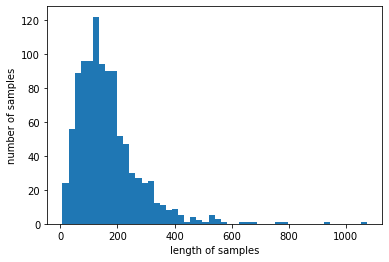

최대 길이: 169405
평균 길이: 164.31134820562562


In [ ]:
tour = pd.read_csv('/content/drive/MyDrive/Insight💡/BigCon/data/비짓제주_관광지2.csv')
tour.drop(index=704,axis=0,inplace=True)
island_of_island = tour[tour.지역.apply(lambda x: x.strip().split('>')[1].strip()[-1] in ['도', '1'])].index
tour = tour.drop(island_of_island)
tour = tour.reset_index(drop=True)

# 텍스트 정제
def cleansing(text):
    pattern = '[\r|\n]'
    text = re.sub(pattern=pattern,repl=' ',string=text)

    pattern = '[^\w|\s]'
    text = re.sub(pattern=pattern,repl=' ',string=text)

    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern,repl=' ',string=text)

    text = text.replace('상세정보 확장됨' ,'')

    return text

from konlpy.tag import Okt  
okt=Okt() 

# 불용어 목록
f = open('/content/drive/MyDrive/Insight💡/BigCon/data/stopwords.txt', 'r')
stopwords = []
lines = f.readlines()
for line in lines:
    line = line.strip()
    stopwords.append(line)
f.close()

# 토큰화
def tokenize(x):
    word_token = okt.morphs(x)
    result = [w for w in word_token if not w in stopwords]
    return result

# 품사 태깅
def pos(x):
    word_token = okt.pos(x)
    result = [w for w in word_token if not w[0] in stopwords]
    return result

# 단어 인코딩
def encoding(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.word_index

# 관광지별 태그 list
def tag_split(x):
    x = x.replace('\n','')
    lst = []
    for t in x.split('#'):
        lst.append(t.strip())
    lst.remove('')
    return lst

tour['상세텍스트'] = tour['상세텍스트'].apply(lambda x: cleansing(x))
tour['tokenize'] = tour['상세텍스트'].apply(lambda x: tokenize(x))
tour['pos'] = tour['상세텍스트'].apply(lambda x: pos(x))
tour['noun'] = tour['pos'].apply(lambda x: [w[0] for w in x if w[1]=='Noun'])  # 명사 추출
tour['encoding'] = tour['tokenize'].apply(lambda x: encoding(x))
tour['len'] = tour['tokenize'].apply(lambda x: len(x))
tour['tag_lst'] = tour['태그'].apply(lambda x: tag_split(x))

plt.hist(tour['len'],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('최대 길이:',tour['len'].sum())
print('평균 길이:',tour['len'].mean())

## 2. 워드 임베딩

In [ ]:
# 단어 벡터 생성
tokens = list(tour['tokenize'].values)
w2v_total = Word2Vec(sentences=tokens, size=150, window=3, min_count=1, workers=4, iter=50, sg=1)

# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(w2v_total.wv[i])
        except KeyError as e:
            pass
    try:
        return np.mean(vector, axis=0)
    except IndexError as e:
        pass

tour['wv_total'] = tour['tokenize'].map(get_sentence_mean_vector)

In [ ]:
tour.head(2)

,이름,지역,태그,주소,좋아요,찜하기,리뷰,방문했어요,조회,SNS공유,...,주변음식점,주변숙박개수,주변숙박,tokenize,pos,noun,encoding,len,tag_lst,wv_total
0,성산일출봉(UNESCO 세계자연유산),서귀포시 > 성산,#일출 #오름 #경관/포토\n#부모 #자연경관 #포토스팟 #유네스코,제주특별자치도 서귀포시 성산읍 일출로 284-12,286.0,"3,653",590.0,21.0,"569,307",711,...,"['맛나식당', '성산회관', '경미네집(경미휴게소)', '바다의집', '그리운바다...",28.0,"['아름다운리조트', '플레이스 캠프 제주', '골든튤립 제주 성산호텔', '봄그리...","[현재, 성산일출봉, 새로운, 일상, 위, 하여, 사회, 적, 거리, 두기, 의무,...","[(현재, Noun), (성산일출봉, Noun), (새로운, Adjective), ...","[현재, 성산일출봉, 일상, 위, 사회, 거리, 두기, 의무, 조치, 해제, 이, ...","{'이': 1, '성산일출봉': 2, '에는': 3, '등': 4, '도': 5, ...",431,"[일출, 오름, 경관/포토, 부모, 자연경관, 포토스팟, 유네스코]","[0.15938465, 0.12701662, 0.07805064, 0.0964706..."
1,사려니숲길,제주시 > 조천,#숲길 #걷기/등산 #친구\n#커플 #흐림 #봄 #자연경관 #도보여행 #도보 #숲 #단풍,제주특별자치도 제주시 조천읍 교래리 산 137-1,213.0,"2,985",503.0,11.0,"700,036","1,125",...,[],0.0,[],"[사려, 니, 숲길, 제주, 숨은, 비경, 31, 중, 하나로, 비자림, 로, 시작...","[(사려, Noun), (니, Josa), (숲길, Noun), (제주, Noun)...","[사려, 숲길, 제주, 비경, 중, 하나로, 비자림, 로, 시작, 물찻오름, 사려,...","{'숲길': 1, '사려': 2, '니': 3, '오름': 4, '한': 5, '탐...",352,"[숲길, 걷기/등산, 친구, 커플, 흐림, 봄, 자연경관, 도보여행, 도보, 숲, 단풍]","[0.01748612, -0.03927376, -0.00043965832, 0.30..."


## 3. 클러스터링

In [ ]:
# K-Means 클러스터링
word_vectors = tour.wv_total.to_list() 
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters, random_state=np.random.RandomState(seed=1))
kmeans_clustering.fit(word_vectors)
pickle.dump(kmeans_clustering, open('kmeans_6','wb'))
idx = kmeans_clustering.fit_predict( word_vectors )
tour['category'] = idx

In [ ]:
# t-SNE
X = tour['wv_total'].to_list()
y = tour['category'].to_list()

tsne_filepath = 'tsne_total.pickle'

if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else:
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)

tour[['x_coord','y_coord']] = tsne_points

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tsne_df = tour[['이름','tag_lst','주요목적','category','x_coord','y_coord']]
tsne_df.head(2)

,이름,tag_lst,주요목적,category,x_coord,y_coord
0,성산일출봉(UNESCO 세계자연유산),"[일출, 오름, 경관/포토, 부모, 자연경관, 포토스팟, 유네스코]",등산,2,-1.646734,8.168561
1,사려니숲길,"[숲길, 걷기/등산, 친구, 커플, 흐림, 봄, 자연경관, 도보여행, 도보, 숲, 단풍]",NaN,3,12.927410,23.565147


In [ ]:
# plotting
output_notebook()

colors = brewer["Set1"][len(tsne_df['category'].unique())]
colormap = {i: colors[i] for i in tsne_df['category'].unique()}
colors = [colormap[x] for x in tsne_df['category']]
tsne_df['color'] = colors

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

tsne_plot = figure(
    title='TSNE Total Text',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl")

tsne_plot.add_tools(
    HoverTool(tooltips=[('관광지','@{이름}'),
                        ('클러스터','@{category}'),
                        ('태그','@{tag_lst}'),
                        ('주요목적','@{주요목적}')]))

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color'
)

show(tsne_plot)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
save(tsne_plot, 'tsne_final.html', title='tour_clustering_final_tsne')

'/content/tsne_final.html'

In [ ]:
# 클러스터별 관광지 목록
# cluster 0
print('cluster 0')
print(tsne_df[tsne_df.category==0]['이름'].values)
print('--------------------------------------------------------')

# cluster 1
print('cluster 1')
print(tsne_df[tsne_df.category==1]['이름'].values)
print('--------------------------------------------------------')

# cluster 2
print('cluster 2')
print(tsne_df[tsne_df.category==2]['이름'].values)
print('--------------------------------------------------------')

# cluster 3
print('cluster 3')
print(tsne_df[tsne_df.category==3]['이름'].values)
print('--------------------------------------------------------')

# cluster 4
print('cluster 4')
print(tsne_df[tsne_df.category==4]['이름'].values)
print('--------------------------------------------------------')

# cluster 5
print('cluster 5')
print(tsne_df[tsne_df.category==5]['이름'].values)

cluster 0
['오설록티뮤지엄' '에코랜드 테마파크' '아쿠아플라넷 제주' '한림공원' '방주교회' '성이시돌목장'
 '더럭초등학교(구, 더럭분교)' '노리매공원' '중문관광단지' '선녀와나무꾼' '제주돌문화공원' '이중섭거리' '여미지식물원'
 '제주유리의성' '소인국테마파크' '제주민속촌' '헬로키티아일랜드' '제주러브랜드[휴업중]' '박물관은 살아있다' '본태박물관'
 '제주특별자치도 도립미술관' '서귀포잠수함(대국해저관광)' '세계자동차 & 피아노박물관' '감귤박물관' '생각하는정원'
 '제주항공우주박물관' '일출랜드' '탑동' '이중섭미술관' '서귀포치유의숲' '제주공룡랜드[휴장중]' '한라수목원'
 '제주현대미술관' '제주해양동물박물관' '테디베어뮤지엄제주' '민속자연사박물관' '1100고지습지' '제주커피박물관 바움 Baum'
 '제주목관아' '교래자연휴양림' '북촌돌하르방미술관' '제주유리박물관' '한라생태숲' '건강과성박물관' '렛츠런파크'
 '산방산탄산온천' '상효원' '제주별빛누리공원[제한적운영중]' '제주센트럴파크' '금능석물원' '제주도립김창열미술관'
 '국립제주박물관' '서귀포천문과학문화관' '저지 예술인 마을' '조랑말체험공원' '테디베어사파리 테지움'
 '그리스신화박물관 / 트릭아이미술관' '대장금촬영지(제주민속촌)' '제주국제컨벤션센터 icc' '초콜릿박물관' '도순다원'
 '신화테마파크' '아라리오뮤지엄탑동시네마' '우포토 시네마 갤러리 카페' '문화예술마을 저지리 농어촌체험마을'
 '탐나라공화국(제주남이섬)' '산지천' '제주아트서커스' '김만덕객주' '세계조가비박물관' '제주 삼양동 유적'
 '제주세계자연유산센터' '제주실탄사격장' '청초밭영농조합법인' '탑동해변공연장' '플레이네이쳐' '라온골프클럽' '방림원'
 '석부작박물관' '아프리카박물관' '북촌국민학교' '제주 메이 더 호텔 카라반빌리지' '클럽나인브릿지'
 '그대, 나의 뮤즈 : 클림트 to 마티스' '김만덕기념관' '미천굴' '바이나흐튼 크리스마스 박물관'

In [ ]:
# 클러스터별 빈도수 TOP 10 명사
cluster_num = 6
cluster_tag = pd.DataFrame()
tag_num = 10

for i in range(cluster_num):
    tag_lst = []
    for m in list(tour[tour.category==i]['tag_lst']):
        for n in m:
            tag_lst.append(n)
    tag_df = list(pd.DataFrame(tag_lst)[0].value_counts().index[:tag_num])
    cluster_tag[f'cluster{i}'] = tag_df
cluster_tag

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5
0,어트랙션,의료관광,역사유적,자연경관,오름,어트랙션
1,실내관광지,어트랙션,문화관광,맑음,자연경관,체험
2,문화관광,스파,문화유적지,커플,도보,레저/체험
3,아이,호텔,어트랙션,해변,도보여행,액티비티
4,실내,체험,자연경관,친구,친구,어린이
5,미술/박물관,웰니스,4.3,포토스팟,커플,아이
6,커플,뷰티,제주4.3,경관/포토,걷기/등산,커플
7,어린이,테라피,커플,걷기/등산,맑음,친구
8,사계절,헬스케어,맑음,어트랙션,혼자,맑음
9,비.눈,관광지,친구,여름,부모,체험관광


In [ ]:
# cluster1(의료관광) 제외
tour.drop(index=tour[tour['category']==1].index,axis=0,inplace=True)
tour.reset_index(drop=True,inplace=True)

In [ ]:
# 클러스터 재구성
tour.loc[tour[tour.category.isin([4])].index,'category_new'] = '오름'
tour.loc[tour[tour.category.isin([3])].index,'category_new'] = '자연경관'
tour.loc[tour[tour.category.isin([2])].index,'category_new'] = '문화유적지'
tour.loc[tour[tour.category.isin([0,5])].index,'category_new'] = '액티비티'

In [ ]:
# plotting
tour.loc[tour[tour.category_new.isin(['자연'])].index,'category_new_num'] = 0
tour.loc[tour[tour.category_new.isin(['액티비티'])].index,'category_new_num'] = 1
tour.loc[tour[tour.category_new.isin(['문화유적지'])].index,'category_new_num'] = 2
tour['category_new_num'] = tour['category_new_num'].astype('int')

tsne_new_df = tour[['이름','tag_lst','주요목적','category_new_num','category','x_coord','y_coord']]
output_notebook()

colors=['#191970','#228B22','#B22222']

colormap = {i: colors[i] for i in tsne_new_df['category_new_num'].unique()}
colors = [colormap[x] for x in tsne_new_df['category_new_num']]
tsne_new_df['color'] = colors

plot_data = ColumnDataSource(
    data=tsne_new_df.to_dict(orient='list')
)

tsne_new_plot = figure(
    title='TSNE Total Text',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl")

tsne_new_plot.add_tools(
    HoverTool(tooltips=[('관광지','@{이름}'),
                        ('클러스터','@{category}'),
                        ('태그','@{tag_lst}'),
                        ('주요목적','@{주요목적}')]))

tsne_new_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color'
)

show(tsne_new_plot)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
save(tsne_new_plot, 'tsne_final_revised.html', title='tnse_final_revised')

'/content/tsne_final_revised.html'

## 4. 지표 점수화

In [ ]:
# 클러스터별 중심점
# 자연1 (cluster 4) center point
cluster_4 = kmeans_clustering.cluster_centers_[4]

# 자연2 (cluster 3) center point
cluster_3 = kmeans_clustering.cluster_centers_[3]

# 자연 center point
nature_center = (cluster_3+cluster_4)/2
# 
# 액티비티 center point
cluster_0 = kmeans_clustering.cluster_centers_[0]
cluster_5 = kmeans_clustering.cluster_centers_[5]
activity_center = (cluster_0+cluster_5)/2

# 문화유적지 center point
history_center = kmeans_clustering.cluster_centers_[2]

In [ ]:
# 중심점과의 거리 계산
from scipy.spatial import distance

def cluster_4_dist(x):
    dist = distance.euclidean(x,cluster_4)
    return dist

def cluster_3_dist(x):
    dist = distance.euclidean(x,cluster_3)
    return dist

def nature_dist(x):
    dist = distance.euclidean(x,nature_center)
    return dist

def activity_dist(x):
    dist = distance.euclidean(x,activity_center)
    return dist

def history_dist(x):
    dist = distance.euclidean(x,history_center)
    return dist

tour['nature'] = 0
for i in range(len(tour)):
    if tour.loc[i,'category']==3:
        tour.loc[i,'nature'] = cluster_3_dist(tour.loc[i,'wv_total'])
    elif tour.loc[i,'category']==4:
        tour.loc[i,'nature'] = cluster_4_dist(tour.loc[i,'wv_total'])
    else:
        tour.loc[i,'nature'] = nature_dist(tour.loc[i,'wv_total'])
tour['activity'] = tour['wv_total'].apply(lambda x: activity_dist(x))
tour['history'] = tour['wv_total'].apply(lambda x: history_dist(x))

In [ ]:
# 점수 Scaling
from sklearn.preprocessing import MinMaxScaler

# 자연
nature_scaler = MinMaxScaler()
tour['nature_scaled'] = nature_scaler.fit_transform(tour[['nature']])

# 액티비티
activity_scaler = MinMaxScaler()
tour['activity_scaled'] = activity_scaler.fit_transform(tour[['activity']])

# 문화유적지
history_scaler = MinMaxScaler()
tour['history_scaled'] = history_scaler.fit_transform(tour[['history']])

In [ ]:
# 최종 점수 계산
tour['nature_score'] = tour['nature_scaled'].apply(lambda x: (1-x)**2)
tour['activity_score'] = tour['activity_scaled'].apply(lambda x: (1-x)**2)
tour['history_score'] = tour['history_scaled'].apply(lambda x: (1-x)**2)

In [ ]:
tour.groupby('category_new').agg({'nature_score':'mean','activity_score':'mean','history_score':'mean'})

,nature_score,activity_score,history_score
category_new,,,
문화유적지,0.376759,0.355032,0.670845
액티비티,0.284036,0.533730,0.351672
자연,0.625013,0.351415,0.437761


In [ ]:
tour[tour.이름.str.contains('정방폭포')]

,이름,지역,태그,주소,좋아요,찜하기,리뷰,방문했어요,조회,SNS공유,...,category_new,nature,activity,history,nature_scaled,activity_scaled,history_scaled,nature_score,activity_score,history_score
27,정방폭포,서귀포시 > 서귀포시내,#폭포 #경관/포토 #커플\n#여름 #자연경관 #포토스팟,제주특별자치도 서귀포시 칠십리로214번길 37,28.0,"1,191",122.0,7.0,"132,783",85,...,문화유적지,0.903531,0.968255,0.55999,0.235670,0.212782,0.001205,0.584201,0.619712,0.997592
216,소정방폭포,서귀포시 > 서귀포시내,#부모 #커플 #친구\n#아이 #맑음 #경관/포토 #폭포 #자연경관 #포토스팟 #어린이,제주특별자치도 서귀포시 칠십리로214번길 17-17,1.0,130,9.0,0.0,"12,453",5,...,자연,1.030446,1.368308,1.11210,0.293159,0.454808,0.272267,0.499624,0.297234,0.529596


In [ ]:
tour.to_csv('tour_score_revised.csv',encoding='utf-8-sig',index=False)

In [ ]:
tour.columns

Index(['이름', '지역', '태그', '주소', '좋아요', '찜하기', '리뷰', '방문했어요', '조회', 'SNS공유',
       '소개', '상세정보', '이용시간', '요금정보', '장소특성', '주요목적', '주요목적기타', '평균소요시간',
       '경사도난이도', '편의시설', '기타상세', '상세텍스트', '주변관광지개수', '주변관광지', '주변음식점개수',
       '주변음식점', '주변숙박개수', '주변숙박', 'tokenize', 'pos', 'noun', 'encoding', 'len',
       'tag_lst', 'wv_total', 'category', 'x_coord', 'y_coord', 'category_new',
       'nature', 'activity', 'history', 'nature_scaled', 'activity_scaled',
       'history_scaled', 'nature_score', 'activity_score', 'history_score'],
      dtype='object')

In [ ]:
tour_save = tour.copy()
tour_save.drop(columns=['tokenize', 'pos', 'noun', 'encoding', 'len',
       'tag_lst', 'wv_total', 'category', 'x_coord', 'y_coord', 'category_new',
       'nature', 'activity', 'history', 'nature_scaled', 'activity_scaled',
       'history_scaled'],axis=1,inplace=True)

In [ ]:
tour_save.to_csv('tour_score_revised.csv',encoding='utf-8-sig',index=False)